In [2]:
!nvidia-smi

Sat Jan  9 15:12:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    13W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Mount google drive where files are located
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set up 
import os
from os import listdir
import keras

from keras import backend as K  
from keras import models
from keras import layers
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image

import gc
import glob

from PIL import Image
from imageio import imread

np.random.seed(5)

In [5]:
listdir('/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/new-data')

['train', 'validation', 'test']

In [6]:
# Define directories for training and test images
base_path = '/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/new-data'

train_data_path = os.path.join(base_path, 'train/')
val_data_path = os.path.join(base_path, 'validation/')
test_data_path = os.path.join(base_path, 'test/')


In [7]:
species = listdir(train_data_path)
print(species)

['bgs', 'chk', 'cls', 'cwd', 'cbl', 'wht', 'fhn', 'lsb', 'mze', 'smw', 'shp', 'sbt']


In [8]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', # monitor validation loss for improvements
    factor = 0.5, # the factor that the learning rate will be multiplied by to decrease it
    patience = 3, # after 3 epochs the learning rate will be decreased
    min_lr = 0.0005, # the minimum learning rate that the model can go to
    verbose = 1) # set verbose to 1 so its visible

early_stop = tf.keras.callbacks.EarlyStopping(
              monitor = 'val_loss', # also monitor validation loss for improvements
              patience = 10, # patience of 10 epochs before early stopping
              verbose = 1) # make visible

In [18]:
# Rescale images 
train_datagen3 = ImageDataGenerator(
      rescale = 1/255, # this rescales the images so the values are between 0 and 1
      horizontal_flip = True, 
      vertical_flip = True,
      brightness_range = [0.5, 1.5]) # darkens or lightens the image each way by 50%

val_datagen3 = ImageDataGenerator(
    rescale = 1/255, 
      horizontal_flip = True, 
      vertical_flip = True,
      brightness_range = [0.5, 1.5])

test_datagen = ImageDataGenerator(
    rescale = 1/255
)

In [10]:
# Generate images for model
print("Total images in training data set:")
train_generator3 = train_datagen3.flow_from_directory(
    train_data_path,
    target_size = (299, 299),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 64,
    shuffle = True
)

print("Total images in validation data set")
val_generator3 = val_datagen3.flow_from_directory(
    val_data_path,
    target_size = (299, 299),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 64,
    shuffle = True
)

Total images in training data set:
Found 4939 images belonging to 12 classes.
Total images in validation data set
Found 300 images belonging to 12 classes.


In [11]:
# define pretrained Xception base
pretrained_base4 = xception.Xception(input_shape=[299, 299, 3],
                                     weights = 'imagenet',
                                     include_top=False)
pretrained_base4.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


In [12]:
# Create full model with new densely connected classifier
model6 = tf.keras.Sequential([
    pretrained_base4, # this is the pretrained Xception base from above 
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = -1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = -1),

    tf.keras.layers.Dense(12, activation = 'softmax') # this should be number of classes?
])

In [13]:
# Compile model with optimiser, loss and metrics
model6.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [14]:
# Fit the model using the training data
result6 = model6.fit(train_generator3,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_generator3,
                    callbacks = [reduce_lr, early_stop])

Epoch 1/50
78/78 [==============================] - 2202s 28s/step - loss: 1.6209 - accuracy: 0.4789 - val_loss: 0.9055 - val_accuracy: 0.6800
Epoch 2/50
78/78 [==============================] - 70s 890ms/step - loss: 0.7336 - accuracy: 0.7358 - val_loss: 0.6347 - val_accuracy: 0.7733
Epoch 3/50
78/78 [==============================] - 70s 892ms/step - loss: 0.6498 - accuracy: 0.7632 - val_loss: 0.6225 - val_accuracy: 0.7933
Epoch 4/50
78/78 [==============================] - 70s 894ms/step - loss: 0.5594 - accuracy: 0.8051 - val_loss: 0.5194 - val_accuracy: 0.8067
Epoch 5/50
78/78 [==============================] - 71s 903ms/step - loss: 0.5286 - accuracy: 0.8190 - val_loss: 0.4880 - val_accuracy: 0.8433
Epoch 6/50
78/78 [==============================] - 70s 897ms/step - loss: 0.5059 - accuracy: 0.8158 - val_loss: 0.6192 - val_accuracy: 0.8000
Epoch 7/50
78/78 [==============================] - 70s 900ms/step - loss: 0.4810 - accuracy: 0.8372 - val_loss: 0.5954 - val_accuracy: 0.7967

Increasing image size to 200x200x3 has increased training accuray to around 90% and validation accuracy to 84%.

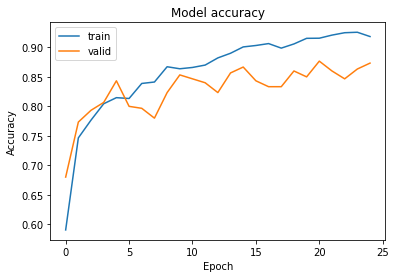

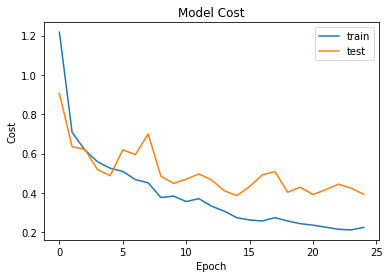

In [16]:
plt.plot(result6.history['accuracy'], label='train')
plt.plot(result6.history['val_accuracy'], label='valid')
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(result6.history['loss'], label='train')
plt.plot(result6.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

In [1]:
test_evaluate = model6.evaluate(test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(299, 299), 
                                                        color_mode='rgb',
                                                        class_mode='categorical',
                                                        batch_size = 64,
                                                        shuffle = True))

NameError: ignored